In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import transformers as tfms
import torchvision as tv
from torchvision import transforms
import os

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

from sklearn.preprocessing import OrdinalEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:

def seed_everything(seed=42):
    """
    Sets the seed for reproducibility across different libraries to ensure
    deterministic results when running a model.

    Args:
        seed (int): The seed value to be used. Default is 42.
    """
    # Set seed for PyTorch (CPU)
    torch.manual_seed(seed)

    # Set seed for PyTorch (GPU)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Set seed for NumPy (for handling random operations in NumPy)
    np.random.seed(seed)

    # Set seed for Python's built-in random module (for general randomness)
    random.seed(seed)

    # Ensure deterministic behavior in CUDA operations (if using GPU)
    torch.backends.cudnn.deterministic = True  # Forces deterministic mode
    torch.backends.cudnn.benchmark = False  # Disables performance optimizations that introduce randomness

    # Ensures deterministic algorithms are used in PyTorch
    torch.use_deterministic_algorithms(True)

    print(f"Global seed set to {seed}")

# Call the function to set the seed
seed_everything()


Global seed set to 42


## Importing the Dataset:

In [259]:
def load_images_from_folders(root_dir):

    images = []   # List to store images
    labels = []   # List to store class labels
    
    # Get sorted list of class names (subfolder names)
    class_names = sorted(os.listdir(root_dir))  # Get class names

    # Iterate over each class folder
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        
        # Skip if it's not a directory
        if not os.path.isdir(class_path):
            continue
        
        # Iterate over each image in the class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
           
            # Open the image
            img = Image.open(img_path)
            
            # Append image and class label to lists
            images.append(img)  # Store PIL image
            labels.append(class_name)  # Store class name
    
    # Convert lists to NumPy arrays for efficient processing
    return np.array(images), np.array(labels)        


dataset_dir = "../../Dataset"
Images, Labels = load_images_from_folders(dataset_dir)

In [154]:
np.unique(Labels)  # Checking all the classes in our dataset

array(['Mild_Demented', 'Moderate_Demented', 'Non_Demented',
       'Very_Mild_Demented'], dtype='<U18')

# Data Visualization:

### Visualizing Sample Images:

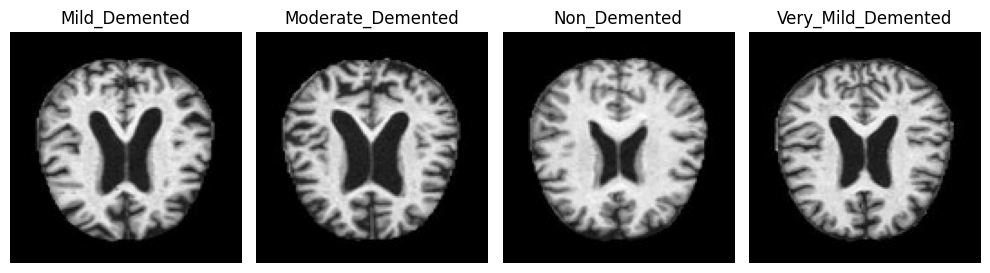

In [48]:
# Create a dictionary to store one image per class
class_to_image = {}

# Iterate through images and labels, storing one image per class
for image, label in zip(Images, Labels):
    if label not in class_to_image:
        class_to_image[label] = image  # Store first image found for each class
    if len(class_to_image) == len(set(Labels)):  # Stop when we have all classes
        break

# Sort the selected images by class order
sorted_classes = sorted(class_to_image.keys())  # Ensure consistent class order
selected_images = [class_to_image[c] for c in sorted_classes]

# Define figure size
plt.figure(figsize=(10, 20))

# Plot each selected image
for i, (image, label) in enumerate(zip(selected_images, sorted_classes)):
    ax = plt.subplot(1, 4, i + 1)

    # Display image
    plt.imshow(image, cmap="gray")  # Ensure grayscale is displayed properly
    plt.title(label)  # Show actual class name
    plt.axis("off")
    plt.tight_layout()

plt.show()


## Visualizing Class Distribution:

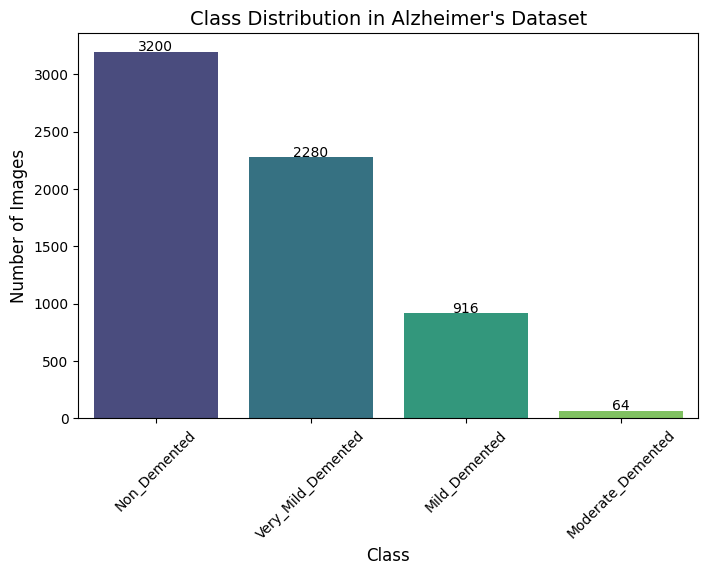

In [155]:
# functioon to plot the class distribution
def plot_class_distribution(Labels):
    # Count occurrences of each class from Labels
    class_counts = Counter(Labels)  # Labels contain class names

    # Sort class names for consistent plotting (descending order of count)
    sorted_classes = sorted(class_counts.keys(), key=lambda x: class_counts[x], reverse=True)
    sorted_counts = [class_counts[c] for c in sorted_classes]

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sorted_classes, y=sorted_counts, hue= sorted_classes, legend= False, palette="viridis")

    # Labels and title
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title("Class Distribution in Alzheimer's Dataset", fontsize=14)
    plt.xticks(rotation=45)  # Rotate class labels for readability

    # Show count on top of bars
    for i, count in enumerate(sorted_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=10)

    plt.show()
    
plot_class_distribution(Labels)

As illustrated in the above plot,there is a lot of class imbalance in the dataset. We will use different transformation to oversample the minority classes to balance the dataset.

# Data Preprocessing:

### Image Augmentation:

In [ ]:
# Setting Random Seed for Reproducibility
random.seed(42)
np.random.seed(42)

# Define Image Augmentations 
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),  # Adjust brightness & contrast randomly
    A.GaussianBlur(p=0.2),  # Apply Gaussian blur
    A.ElasticTransform(p=0.2),  # Apply elastic deformation (mimics natural distortions)
    A.GridDistortion(p=0.2),  # Distort image using a grid pattern
    A.OpticalDistortion(p=0.2),  # Simulate lens distortions
    A.RandomGamma(p=0.5)],  # Randomly adjust gamma levels
    seed= 42)

def apply_augmentation(image, num_augments):
    augmented_images = []
    for _ in range(num_augments):
        aug_image = transform(image=image)["image"]
        augmented_images.append(aug_image)
    return augmented_images

def balance_classes(images, labels, target_count):
    new_images, new_labels = [], []
    
    # Get unique class names and their respective counts
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    
    # Dictionary to store images by class
    class_to_images = {cls: [] for cls in unique_classes}

    # Group images by class
    for img, lbl in zip(images, labels):
        class_to_images[lbl].append(img)

    # Oversample each class
    for cls in unique_classes:
        class_images = class_to_images[cls]
        current_count = len(class_images)

        # Keep original images
        new_images.extend(class_images)
        new_labels.extend([cls] * current_count)

        # Calculate how many augmentations needed
        num_augments = target_count - current_count
        for i in range(num_augments):
            original_img = random.choice(class_images)  # Pick random image from the class
            aug_images = apply_augmentation(original_img, 1)
            new_images.extend(aug_images)
            new_labels.append(cls)

    return np.array(new_images), np.array(new_labels)

# Find the maximum class count
max_count = max(np.unique(Labels, return_counts=True)[1])

# Apply oversampling
random.seed(42)
balanced_images, balanced_labels = balance_classes(Images, Labels, max_count)

print(f"Balanced dataset shape: {balanced_images.shape}, Labels shape: {balanced_labels.shape}")


Balanced dataset shape: (12800, 128, 128), Labels shape: (12800,)


### Visualizing the class distribution after augmentation:

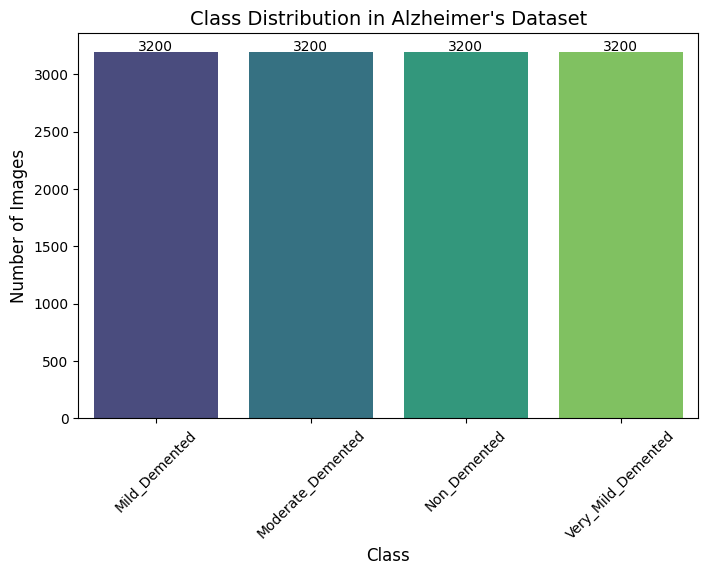

In [53]:
plot_class_distribution(balanced_labels)

As shown in the above figure, we balanced the dataset.

In [261]:
# Saving the Images and Labels for future use.
np.save(file='Augmented_Images', arr=balanced_images)
np.save(file= 'Augmented_Labels', arr= balanced_labels)

Loading data from storage

In [2]:
# Loading the Images and labels from the sorage
balanced_images = np.load('Augmented_Images.npy')
balanced_labels = np.load('Augmented_Labels.npy')

### Normalizing Images:

In [3]:
normalized_images = balanced_images.astype(np.float32) /  255  # Normalize the pixel values to the range [0, 1]

mean = np.mean(normalized_images)     
std = np.std(normalized_images)
print("Mean:", mean, "Std:", std)

Mean: 0.2780612 Std: 0.31929433


The standard deviation is fine but the mean tends towards negative which can cause unstable training. 

### One Hot Encoding:

Converting int labels to array labels for deep learning.

In [ ]:
# Define the correct order of classes
class_order = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

# Create a mapping from class name to one-hot encoding
class_to_one_hot = {cls: np.eye(len(class_order))[i] for i, cls in enumerate(class_order)}

# Convert labels to one-hot encoded format
one_hot_labels = np.array([class_to_one_hot[label] for label in balanced_labels])

random.seed(42)
# Print 5 random samples 
print("One-hot encoded labels (random samples):")
for _ in range(5):
    idx = random.randrange(len(one_hot_labels))
    print(f"Label: {balanced_labels[idx]}, One-hot: {one_hot_labels[idx]}")

One-hot encoded labels (random samples):
Label: Very_Mild_Demented, One-hot: [0. 1. 0. 0.]
Label: Mild_Demented, One-hot: [0. 0. 1. 0.]
Label: Mild_Demented, One-hot: [0. 0. 1. 0.]
Label: Very_Mild_Demented, One-hot: [0. 1. 0. 0.]
Label: Moderate_Demented, One-hot: [0. 0. 0. 1.]


### Split the data into training and testing sets:

In [6]:
from sklearn.model_selection import train_test_split    

X = torch.from_numpy(normalized_images).unsqueeze(1)  # convert to torch tensor add a channel dimension
y = torch.from_numpy(one_hot_labels)                  # convert to torch tensor                                                                                    

# First, split into train (80%) and temp (20%) [val+test]
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify= balanced_labels)  # Stratify ensures that the class distribution is maintained in the split

# Now, split temp into validation (10%) and test (10%)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify= y_test) 

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Training set size: 10240
Validation set size: 1280
Test set size: 1280


### Standardizing Images:

Standardization should be done after splitting the data into train and testsets because:
- Data Leakage: if we standardize the data before splitting, the test data will have access to the mean and standard deviation of the training data, which could lead to information leakage and bias the model's performance. 
- And also the mean and std of both the sets differs if standardized before splitting.

train, val and test sets should be standardized with the same mean and std retrieved from the training set which is the best practise.

In [7]:

train_mean = torch.mean(x_train) 
train_std = torch.std(x_train)

x_train = (x_train - train_mean) / train_std
x_val = (x_val - train_mean) / train_std
x_test = (x_test - train_mean) / train_std  

print(f'mean: {train_mean}, std: {train_std} before standardization')
print(f'train set mean: {torch.mean(x_train)}, std: {torch.std(x_train)} after standardization')
print(f'validation set mean: {torch.mean(x_val)}, std: {torch.std(x_val)} after standardization')
print(f'test set mean: {torch.mean(x_test)}, std: {torch.std(x_test)} after standardization')

mean: 0.27777689695358276, std: 0.31906041502952576 before standardization
train set mean: -1.3587995795205643e-07, std: 1.0 after standardization
validation set mean: 0.00418399553745985, std: 1.0046416521072388 after standardization
test set mean: 0.00474061444401741, std: 1.002662181854248 after standardization


## Batching Dataset

Don't send the entire dataset into the cuda device now. you need to send the data in the training loop which reduces memory usage.

In [8]:
# leverage GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)

train_data = DataLoader(TensorDataset(x_train, y_train), batch_size=32)
val_data = DataLoader(TensorDataset(x_val, y_val), batch_size=32)
test_data = DataLoader(TensorDataset(x_test, y_test), batch_size=32)

# Deep Learning:

### Model Building:

Model Architecture:
- 6 convolutional layers progressively extract hierarchical features.
- Deep Feature Extraction: Multiple convolutional layers allow learning detailed patterns in MRI images.
- Uses SiLU (Swish) activation, which helps with smooth gradients and better performance.
- Batch Normalization + Dropout: Helps with stability and reduces overfitting risks.
- Returns logits for 4 classes

In [2]:
torch.manual_seed(42)

class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  
            nn.SiLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),  
            nn.SiLU(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.conv_layers(x)  # 
        x = torch.flatten(x, 1)  # Flatten before FC layer
        x = self.fc(x)
        return x


# Instantiate models
model = CNNModel(num_classes=4).to(device)

In [3]:
from torchinfo import summary

summary(model, input_size=(1, 1, 128, 128))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 4]                    --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         320
│    └─SiLU: 2-2                         [1, 32, 128, 128]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 128, 128]         64
│    └─Conv2d: 2-4                       [1, 64, 64, 64]           18,496
│    └─SiLU: 2-5                         [1, 64, 64, 64]           --
│    └─BatchNorm2d: 2-6                  [1, 64, 64, 64]           128
│    └─Dropout: 2-7                      [1, 64, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 128, 32, 32]          73,856
│    └─SiLU: 2-9                         [1, 128, 32, 32]          --
│    └─BatchNorm2d: 2-10                 [1, 128, 32, 32]          256
│    └─Dropout: 2-11                     [1, 128, 32, 32]          --
│   

Defining the loss function and optimizer with learning rate scheduling.

In [ ]:
from torch import optim
torch.manual_seed(42)

# CrossEntropyLoss (for multi-class classification)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Adam optimizer with weight decay (L2 regularization)
AdamW = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler (optional, helps with convergence)
scheduler = optim.lr_scheduler.CosineAnnealingLR(AdamW, T_max=40, eta_min=1e-6)

### Model Training:

In [ ]:
from torchmetrics import Accuracy

torch.manual_seed(42)
accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

def training_loop(model= model, num_epochs= 1, train_data= train_data, val_data= val_data, criterion= criterion, optimizer= AdamW, scheduler= scheduler, device= device, use_early_stopping=False, patience=5):
    train_losses, val_losses = [], []            # Stores train data metrics
    train_accuracies, val_accuracies = [], []    # Stores validation data metrics

    for epoch in range(num_epochs):
        model.train()                          # Set the model to training mode
        train_loss, train_acc = 0.0, 0.0       # Initialize metrics for the epoch

        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)   # Move data to the device

            optimizer.zero_grad()                # Reset gradients
            outputs = model(images)              # forward pass
            loss = criterion(outputs, labels)    # Compute loss
            loss.backward()                      # backpropagation
            optimizer.step()                     # update weights

            train_loss += loss.item()            # Accumulate loss

            # Compute accuracy
            outputs = torch.argmax(outputs, dim=1)        # Convert to class labels
            labels = torch.argmax(labels, dim=1)          # Convert to class labels
            train_acc += accuracy(outputs, labels)        # Compute accuracy and accumulate it

        # Compute training average loss and accuracy for the epoch
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        # Store training loss and accuracy for plotting
        train_losses.append(train_loss)                
        train_accuracies.append(train_acc.cpu().item())  

        # Validation Step
        model.eval()                       # Set the model to evaluation mode
        val_loss, val_acc = 0.0, 0.0       # Initialize metrics for the epoch
        with torch.no_grad():                 # Disable gradient computation
            for images, labels in val_data:
                
                # Compute val loss                     
                images, labels = images.to(device), labels.to(device)   
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Compute val accuracy
                val_loss += loss.item()
                outputs = torch.argmax(outputs, dim=1)
                labels = torch.argmax(labels, dim=1)
                val_acc += accuracy(outputs, labels)

        # Compute validation average loss and accuracy for the epoch
        val_loss /= len(val_data)
        val_acc /= len(val_data)
        
        # Store validation loss and accuracy for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().item())

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early Stopping Check
        if use_early_stopping:
            if val_loss < best_val_loss:   
                best_val_loss = val_loss      # Update best validation loss
                early_stopping_counter = 0    # Reset counter
            else:                                        
                early_stopping_counter += 1   # Increment counter
                print(f"Early stopping patience: {early_stopping_counter}/{patience}")
                
                if early_stopping_counter >= patience: # Check if patience is reached
                    print("Early stopping triggered. Training stopped.")
                    break                              # Stop training

        # Step LR scheduler (if used)
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
# model training
train_losses, val_losses, train_accuracies, val_accuracies = training_loop(num_epochs=30)

Epoch [1/30] - Train Loss: 0.9723, Train Acc: 0.6382 - Val Loss: 0.8023, Val Acc: 0.7445
Epoch [2/30] - Train Loss: 0.7599, Train Acc: 0.7820 - Val Loss: 0.6457, Val Acc: 0.8422
Epoch [3/30] - Train Loss: 0.6541, Train Acc: 0.8463 - Val Loss: 0.5626, Val Acc: 0.9102
Epoch [4/30] - Train Loss: 0.5890, Train Acc: 0.8928 - Val Loss: 0.5228, Val Acc: 0.9273
Epoch [5/30] - Train Loss: 0.5461, Train Acc: 0.9207 - Val Loss: 0.4978, Val Acc: 0.9422
Epoch [6/30] - Train Loss: 0.5080, Train Acc: 0.9423 - Val Loss: 0.4768, Val Acc: 0.9570
Epoch [7/30] - Train Loss: 0.4943, Train Acc: 0.9511 - Val Loss: 0.4657, Val Acc: 0.9570
Epoch [8/30] - Train Loss: 0.4793, Train Acc: 0.9599 - Val Loss: 0.4700, Val Acc: 0.9586
Epoch [9/30] - Train Loss: 0.4645, Train Acc: 0.9705 - Val Loss: 0.4675, Val Acc: 0.9594
Epoch [10/30] - Train Loss: 0.4565, Train Acc: 0.9759 - Val Loss: 0.4494, Val Acc: 0.9703
Epoch [11/30] - Train Loss: 0.4477, Train Acc: 0.9780 - Val Loss: 0.4534, Val Acc: 0.9625
Epoch [12/30] - Tra

Training accuracy is 99% while validation accuracy is 97% which can be seen as a sign of overfitting but the model is still performs well. Use the test set to evaluate the model.

## Plotting the training history

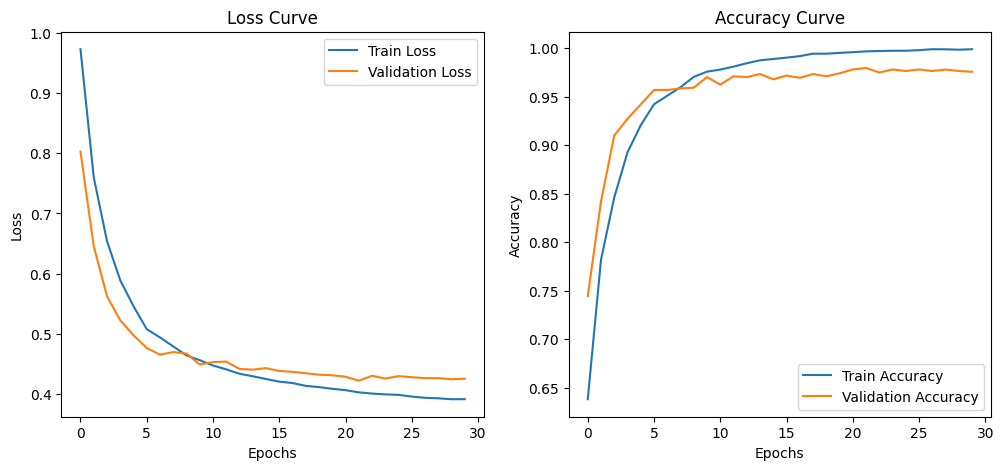

In [ ]:

# Plotting the loss and accuracy curves
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

# Model Evaluation:

### Test Loss and Accuracy

In [ ]:

# Testing Loop
def test_loop(model= model, test_data= test_data, criterion= criterion, device= device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():  # No gradient calculation for testing
        for images, labels in test_data:
            images, labels = images.to(device), labels.to(device) # Move data to device

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            test_loss += loss.item() # Sum up the loss

            # Compute accuracy
            outputs = torch.argmax(outputs, dim=1)  # Get the predicted class
            labels = torch.argmax(labels, dim=1)    # Get the true class
            test_acc += accuracy(outputs, labels)   # Sum up the accuracy

    # Compute average loss and accuracy
    test_loss /= len(test_data)
    test_acc /= len(test_data)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [ ]:
test_loop() # Printing the test set loss and accuracy

Test Loss: 0.4290, Test Acc: 0.9719


Test loss and accuracy resembles the val loss and accuracy which means there is no data leakage which is good and the model performs well on the test data with an overall accuracy of 97%.

### Classification Report:

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions
true_labels = []
pred_labels = []

class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

model.eval()
with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(outputs.cpu().numpy())
        
true_labels= np.argmax(true_labels, axis=1)
pred_labels= np.argmax(pred_labels, axis=1)

# Getting the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)

                  precision    recall  f1-score   support

     NonDemented       1.00      1.00      1.00       320
VeryMildDemented       0.95      0.96      0.96       320
    MildDemented       0.98      0.93      0.96       320
ModerateDemented       0.96      0.99      0.98       320

        accuracy                           0.97      1280
       macro avg       0.97      0.97      0.97      1280
    weighted avg       0.97      0.97      0.97      1280



### Confusion Matrix:

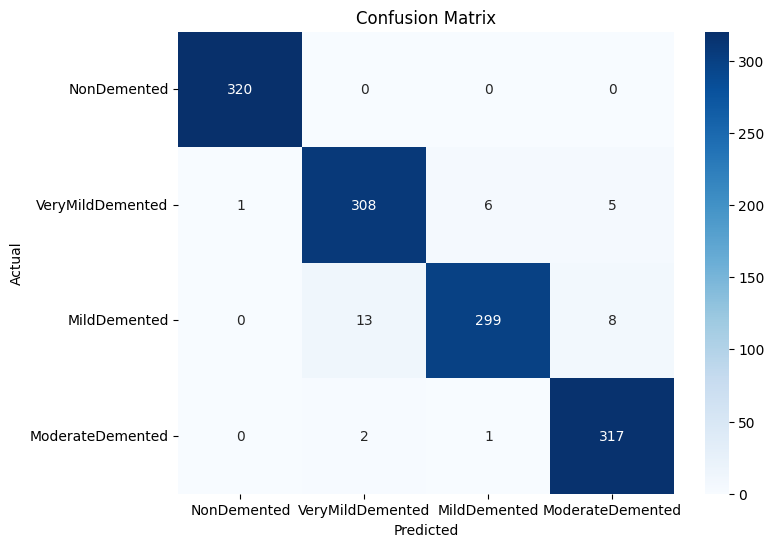

In [22]:
# Compute and plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(outputs.cpu().numpy())
        
# Convert true labels to one-hot encoding
#true_labels_one_hot = torch.nn.functional.one_hot(torch.tensor(true_labels), num_classes=4).numpy()
true_labels = torch.argmax(torch.tensor(true_labels), dim=1).numpy()
pred_probs = torch.nn.functional.softmax(torch.tensor(pred_labels), dim=1).numpy()

Calibration Error:

In [ ]:
from torchmetrics.classification import CalibrationError,MulticlassCalibrationError

ece = CalibrationError(n_bins=10, task="multiclass", num_classes=4 )
calibration_error = ece(torch.tensor(pred_probs), torch.tensor(true_labels))
print(f"Expected Calibration Error: {calibration_error:.4f}")

Expected Calibration Error: 0.0484


Since the calibration error is almost zero, we can conclude that the model is well-calibrated and its predictions are reliable.

AUC Score:

In [52]:
auc_score = roc_auc_score(true_labels, pred_probs, multi_class="ovr")
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9985


Since the AUC score is 0.99, we can say that the model is performing well and is able to distinguish well.

# GRAD CAM:

Visualizing how the model sees the images and where it focuses on the image

In [4]:

# GRAD CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook to get feature maps
        def forward_hook(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(forward_hook)
        #target_layer.register_backward_hook(backward_hook)            don't use this 
        target_layer.register_full_backward_hook(backward_hook)


    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backpropagate for the specific class
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Compute Grad-CAM
        gradients = self.gradients.cpu().data.numpy()[0]  # Gradients from the target class
        
        #gradients2 = np.mean(gradients, axis=(1, 2))  # Example: Averaging across spatial dimensions
        #print("Gradient mean:", gradients)
        
        activations = self.activations.cpu().data.numpy()[0]  # Feature maps
        weights = np.mean(gradients, axis=(1, 2))  # Global Average Pooling

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))  # Resize to input size
        eps = 1e-8  # Small constant to prevent division by zero
        denom = np.max(cam) - np.min(cam)
        if denom == 0:
            #print("Warning: Activation map has zero variance. Assigning a neutral heatmap.")
            cam = np.zeros_like(cam)  # Neutral output
        else:
            cam = (cam - np.min(cam)) / (denom + eps)  # Normalize safely
        return cam
    
# Image Preprocessor
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((128, 128)),  # Change to match your model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.27777689695358276], std=[0.31906041502952576 ])  # Adjust based on dataset
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

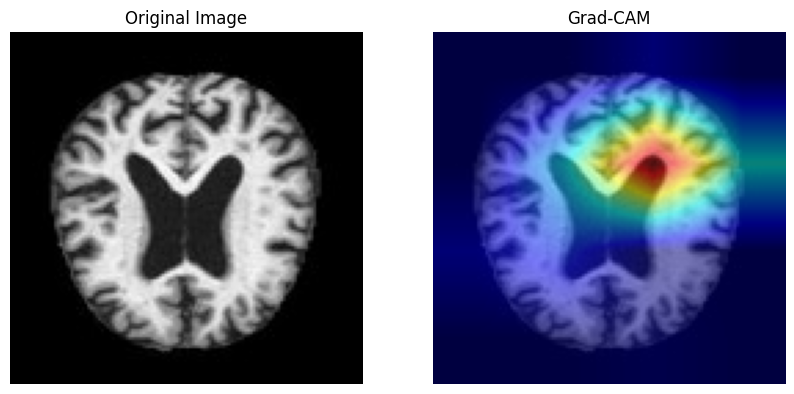

In [9]:


def overlay_heatmap(image, cam, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed

# Load model and define Grad-CAM
target_layer = model.conv_layers[19]  # Change this to the last convolutional layer of your model
grad_cam = GradCAM(model, target_layer)

# Load a sample image
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((128, 128)),  # Change to match your model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.27777689695358276], std=[0.31906041502952576 ])  # Adjust based on dataset
    ])

images = ['non_37.jpg', 'moderate_31.jpg', 'verymild_353.jpg', 'mild_574.jpg'] 

image_path = images[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
input_tensor = transform(image).unsqueeze(0).to(device)

# Generate Grad-CAM
cam = grad_cam.generate_cam(input_tensor)

# Overlay the heatmap on the original image
overlayed_image = overlay_heatmap(np.array(image), cam)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image)
plt.title("Grad-CAM")
plt.axis("off")



plt.show()

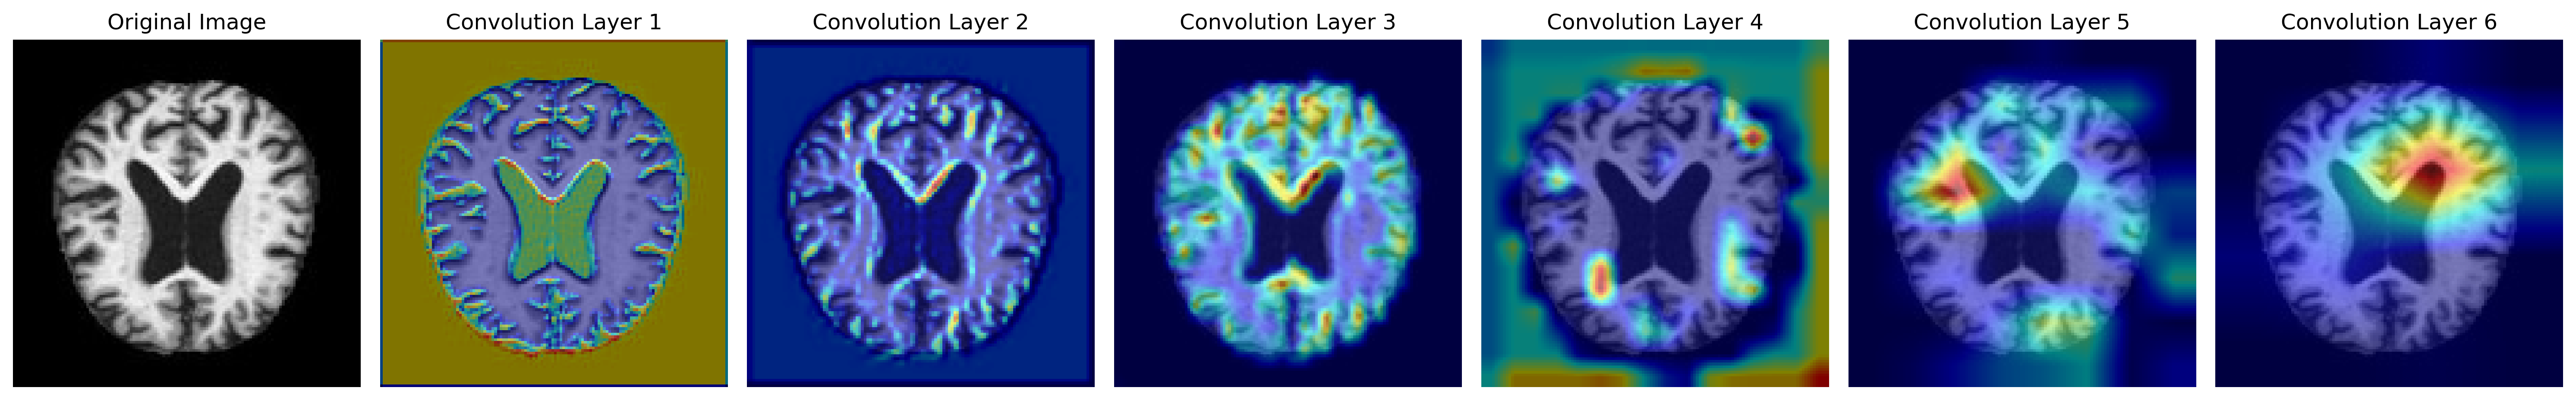

In [10]:
conv_layers = [layer for layer in model.conv_layers if isinstance(layer, torch.nn.Conv2d)]


# Create a figure with 1 row and 7 columns
fig, axes = plt.subplots(1, 7, figsize=(20, 5),dpi = 300)

# Plot the original image first
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Loop through convolutional layers and generate Grad-CAM
for i, conv_layer in enumerate(conv_layers):
    grad_cam = GradCAM(model, conv_layer)
    cam = grad_cam.generate_cam(input_tensor)

    overlayed_image = overlay_heatmap(np.array(image), cam)

    axes[i + 1].imshow(overlayed_image)
    axes[i + 1].set_title(f"Convolution Layer {i+1}")
    axes[i + 1].axis("off")
plt.savefig("grad_cam_plot_1000_dpi.png", dpi=1000, bbox_inches="tight")
# Show the grid of images
plt.tight_layout()
plt.show()




## Save Model Weights:

In [ ]:
# Save the model's state_dict (weights)
torch.save(model.state_dict(), "CNN_Model_Weights.pth")

print("Model weights saved successfully!")

Global seed set to 42
Model weights saved successfully!


### Load model Weights:

In [3]:
# Load model weights
model.load_state_dict(torch.load("CNN_Final.pth",weights_only= True))

# Move model to device (CPU or GPU)
model.to(device)

print("Model weights loaded successfully!")

Model weights loaded successfully!
